# NLP model on bias

In [17]:
import tarfile
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow import keras

# FFNN
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

# RNN
from keras.preprocessing import sequence
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.recurrent import LSTM

In [4]:
#https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ULHLCB
import tarfile

def get_content(member):
    with tar.extractfile(member) as f:
        review = f.read().decode()
        return review

with tarfile.open("data/articles.tar.gz", "r:gz") as tar:
    for member in tar.getmembers():
        print(member)
        '''
        if member.isreg(): 
            if 'train' in member.name:
                if '/neg/' in member.name:
                    score_10 = member.name[-5:-4]
                    score = 0
                    data.append([get_content(member), score, score_10])
                elif '/pos/' in member.name:
                    score_10 = member.name[-6:-4].replace('_','')
                    score = 1
                    data.append([get_content(member), score, score_10])
                else:
                    pass
        '''

visas to help UK fruit farmers' at 0x1a0f0875700>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--A friend to Middle Britain Geordie Greig begins reign as Daily Mail editor' at 0x1a0f0875940>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--Robin Williams curios and mementoes for sale in pictures' at 0x1a0f0875c40>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--10 of the worlds best street food stalls readers travel tips' at 0x1a0f0875b80>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--China complains over British warship sailing through disputed South China Sea' at 0x1a0f0875dc0>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--Thai boys trapped in cave climb through replica video' at 0x1a0f0875e80>
<TarInfo 'articles/2018-09-06/The Guardian UK/The Guardian UK--2018-09-06--What does energy price cap mean for households and firms' at 0x1a0f0875f40>
<Tar

In [7]:
data = pd.read_csv('data/articles1.csv.zip', compression='zip')
data

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...,...
49995,53287,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,53288,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,53289,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,53290,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


In [2]:
data = pd.read_csv('data/newsArticlesWithLabelsAndText.csv')

In [3]:
sub = data.loc[data.perceived == 0]

In [4]:
sub['republican.vote'].unique()

array(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive',
       'Negative'], dtype=object)

In [5]:
train = pd.DataFrame()
train['left'] = sub['democrat.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,-1,1,-1])
train['right'] = sub['republican.vote'].replace(['Neutral', 'SomewhatPositive', 'SomewhatNegative', 'Positive', 'Negative'], [0,1,-1,1,-1])
#train['bias'] = 
train['text'] = sub['text']
df = train.dropna()

In [21]:
train['text'][54]

'MOSCOW (AP) — Former National Security Agency systems analyst Edward Snowden says surveillance programs used by the United States to tap into phone and Internet connections around the world are making people less safe.\n\nIn short video clips posted by the WikiLeaks website on Friday, Snowden said the NSA mass surveillance he revealed before fleeing to Russia "puts us at risk of coming into conflict with our own government."\n\nSnowden, who faces espionage charges in the U.S. over the leak, described the techniques as "dragnet mass surveillance that puts entire populations under sort of an eye that sees everything even when it\'s not needed."\n\n"They hurt our economy. They hurt our country. They limit our ability to speak and think and live and be creative, to have relationships and to associate freely," Snowden said.\n\nThe videos are the first of Snowden speaking since July 12, when he was shown at a Moscow airport pleading with Russian authorities to grant him asylum, which they d

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preclean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('\\s', ' ', text)
    text = re.sub(' +', ' ', text)
    #text = text.split(' ')
    return text

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub('\\s', ' ', text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    text = re.sub(' +', ' ', text)
    #text = text.split(' ')
    return text

tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=2000
)

In [72]:
train['text'][28]

'I’m sure Jeffrey Goldberg got it right. Whatever the reason the President leaked his unhappiness with Bibi to Goldberg just a few days before the Israeli election–whether in an effort to influence the vote against Bibi, serve payback to Bibi for a perceived preference for Romney, or because the President could simply no longer suppress his dissatisfaction–it must indeed be unnerving to be the most powerful man on earth and have the elected leader of a tiny Middle Eastern country defy you. Especially when that country, in your opinion, owes you so much!\n\nYou are their only reliable friend who watches helplessly as that little nation continues to isolate itself through its self-destructive policies. According to Goldberg, Obama has “become inured to what he sees as self-defeating policies of his Israeli counterpart…Obama said privately and repeatedly, “Israel doesn’t know what its own best interests are… Netanyahu is moving his country down a path toward near-total isolation.”\n\nIf o

In [26]:
from keras.utils import to_categorical

# preclean only
#X = df["text"].apply(lambda x: preclean_text(x))

tfidf_fit = tfidf.fit(df["text"])
X = tfidf_fit.transform(df["text"]).toarray()

#y = to_categorical(df[["right","left"]])
y = to_categorical(df["opinion"])
#y = to_categorical(sub['republican.vote'])
#y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)
np.shape(y)

(3575, 2)

In [17]:
import joblib
# Save to file in the current working directory
joblib.dump(tfidf_fit, 'models/tfidf_fit.pkl')

['models/tfidf_fit.pkl']

In [18]:
# FFNN Model
num_classes = 2

model = keras.Sequential()
# Input layer
model.add(Dense(2000, input_dim=2000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              4002000   
_________________________________________________________________
batch_normalization (BatchNo (None, 2000)              8000      
_________________________________________________________________
activation (Activation)      (None, 2000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0

In [19]:
# Fit and evaluate
batch_size = 128
epochs = 20

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/20
21/21 [==============================] - 8s 208ms/step - loss: 0.8235 - accuracy: 0.5356 - val_loss: 0.7092 - val_accuracy: 0.3189
Epoch 2/20
21/21 [==============================] - 4s 168ms/step - loss: 0.5868 - accuracy: 0.7030 - val_loss: 0.7765 - val_accuracy: 0.2928
Epoch 3/20
21/21 [==============================] - 3s 165ms/step - loss: 0.4884 - accuracy: 0.7843 - val_loss: 0.8282 - val_accuracy: 0.2928
Epoch 4/20
21/21 [==============================] - 4s 171ms/step - loss: 0.3984 - accuracy: 0.8635 - val_loss: 0.8821 - val_accuracy: 0.2928
Epoch 5/20
21/21 [==============================] - 3s 167ms/step - loss: 0.3152 - accuracy: 0.9125 - val_loss: 0.9012 - val_accuracy: 0.2928
Epoch 6/20
21/21 [==============================] - 3s 166ms/step - loss: 0.2658 - accuracy: 0.9481 - val_loss: 0.8937 - val_accuracy: 0.2928
Epoch 7/20
21/21 [==============================] - 3s 165ms/step - loss: 0.2527 - accuracy: 0.9550 - val_loss: 0.8597 - val_accuracy: 0.2950
Epoch 

In [62]:
#model.predict(X_test)[:30]

In [20]:
model.save('models/right_bias_model-FFNN_2000_500_100-epochs_20.h5')

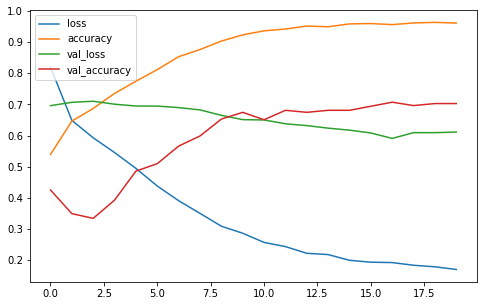

In [72]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab = 1000
max_len = 500

df["text"] = df["text"].apply(lambda x: clean_text(x))
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df["text"])
X = tfidf.fit_transform(df["text"]).toarray()
#y = to_categorical(df[["right","left"]])
y = to_categorical(df["right"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#np.shape(X_train)

<ipython-input-74-edb93c3c070d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(lambda x: clean_text(x))


In [75]:
# GRU Model
num_classes = 2

model = keras.Sequential()
# Input layer
model.add(Embedding(vocab, 128, input_length=max_len))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          128000    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 130       
Total params: 235,458
Trainable params: 235,458
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Fit and evaluate

batch_size = 64
epochs = 5

X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/5
41/41 [==============================] - 299s 7s/step - loss: 0.6425 - accuracy: 0.6873 - val_loss: 0.6066 - val_accuracy: 0.7072
Epoch 2/5
41/41 [==============================] - 303s 7s/step - loss: 0.6270 - accuracy: 0.6810 - val_loss: 0.6050 - val_accuracy: 0.7072
Epoch 3/5
41/41 [==============================] - 299s 7s/step - loss: 0.6319 - accuracy: 0.6758 - val_loss: 0.6101 - val_accuracy: 0.7072
Epoch 4/5
41/41 [==============================] - 299s 7s/step - loss: 0.6163 - accuracy: 0.6963 - val_loss: 0.6069 - val_accuracy: 0.7072
Epoch 5/5
41/41 [==============================] - 298s 7s/step - loss: 0.6174 - accuracy: 0.6942 - val_loss: 0.6120 - val_accuracy: 0.7072
Loss: 61.45
Accuracy: 70.31


In [33]:
model.save('models/right_bias_model-GRU_128-epochs_5.h5')

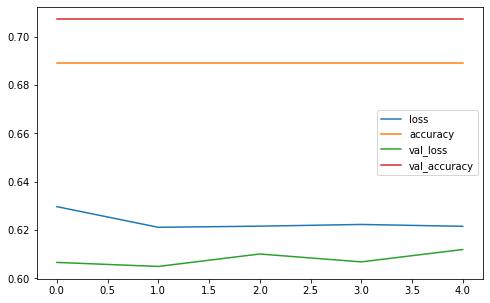

In [77]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [ ]:
#https://towardsdatascience.com/media-bias-detection-using-deep-learning-libraries-in-python-44efef4918d1

In [23]:
op = pd.DataFrame()
op['opinion'] = sub['q3'].replace(['Opinion', 'News', 'other'], [1,0,np.nan])
op['text'] = sub['text']
df = op.dropna()

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub("\\s", " ", text)
    text = re.sub("[^a-zA-Z' ]", "", text)
    #text = text.split(' ')
    return text

tfidf = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    max_features=2000
)

In [33]:
from keras.utils import to_categorical

# preclean only
X = df["text"].apply(lambda x: preclean_text(x))


#X = tfidf.fit_transform(df["text"]).toarray()
#y = to_categorical(df[["right","left"]])
#y = to_categorical(df["opinion"])
#y = to_categorical(sub['republican.vote'])
y = df["opinion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)
np.shape(y)

(3575,)

In [131]:
# FFNN Model
num_classes = 1

model = keras.Sequential()
# Input layer
model.add(Dense(1000, input_dim=1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# hidden layer
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
batch_normalization_56 (Batc (None, 1000)              4000      
_________________________________________________________________
activation_56 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 500)               500500    
_________________________________________________________________
batch_normalization_57 (Batc (None, 500)               2000      
_________________________________________________________________
activation_57 (Activation)   (None, 500)             

In [132]:
# Fit and evaluate
batch_size = 128
epochs = 25

history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=epochs, validation_split=0.15, verbose=1)

scores = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {(scores[0]*100):.2f}')
print(f'Accuracy: {(scores[1]*100):.2f}')

Epoch 1/25
11/11 [==============================] - 6s 136ms/step - loss: 0.7788 - accuracy: 0.5243 - val_loss: 0.6828 - val_accuracy: 0.6432
Epoch 2/25
11/11 [==============================] - 1s 77ms/step - loss: 0.6022 - accuracy: 0.6658 - val_loss: 0.6725 - val_accuracy: 0.6432
Epoch 3/25
11/11 [==============================] - 1s 84ms/step - loss: 0.5303 - accuracy: 0.7569 - val_loss: 0.6667 - val_accuracy: 0.6556
Epoch 4/25
11/11 [==============================] - 1s 76ms/step - loss: 0.4910 - accuracy: 0.8226 - val_loss: 0.6647 - val_accuracy: 0.6349
Epoch 5/25
11/11 [==============================] - 1s 76ms/step - loss: 0.4715 - accuracy: 0.8208 - val_loss: 0.6641 - val_accuracy: 0.6390
Epoch 6/25
11/11 [==============================] - 1s 79ms/step - loss: 0.4416 - accuracy: 0.8703 - val_loss: 0.6638 - val_accuracy: 0.6100
Epoch 7/25
11/11 [==============================] - 1s 77ms/step - loss: 0.4283 - accuracy: 0.8828 - val_loss: 0.6636 - val_accuracy: 0.6141
Epoch 8/25
1

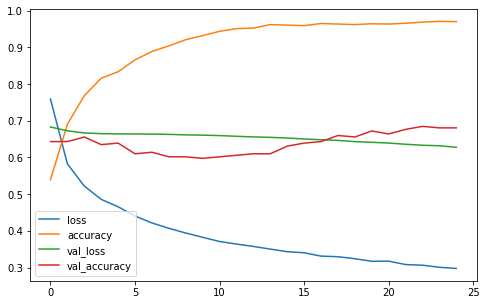

In [133]:
pd.DataFrame(history.history).plot(figsize=(8,5));

In [134]:
pred = model.predict(X_test)
predict = np.where(pred >= 0.5 , 1, 0)

In [38]:
# Evaluate
from sklearn import metrics
# y_test.argmax(axis=1) transform one-hot back to category 
print(metrics.confusion_matrix(y_test,predict))
print(metrics.classification_report(y_test,predict))

NameError: name 'predict' is not defined

In [70]:
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return  X.apply(lambda text: " ".join([self.lemmatizer.lemmatize(word) for word in text.split()]))

In [9]:
import numpy as np
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.base import TransformerMixin, BaseEstimator

class Doc2Vec(BaseEstimator, TransformerMixin):
    def __init__(self, nlp, doc='doc'):
        self.doc = doc
        self.nlp = nlp

    def fit(self, X, y):
        return self

    def transform(self, X):
        if self.doc == 'word':
            # return a vector for each word
            # need more work
            vec = X.apply(lambda text: np.array([self.nlp(w).vector for w in text]) )
        elif self.doc == 'sentense':
            # return a vector for each sentense
            # need more work
            vec = X.apply(lambda text: np.array([self.nlp(s).vector for s in text.split('.')]) )
        else:
            # return a vector for the whole doc 
            vec = X.apply(lambda text: np.array(self.nlp(text).vector))
            #vec = np.array([self.nlp(text).vector for text in X])
        return  pd.DataFrame(vec.values.tolist(), index=vec.index)

In [34]:
X_train

5074     Don’t we need to do a lot more about our socia...
8767     David Jackson USA TODAY President Obama says h...
6519     President Biden is introducing a policy that w...
345      8 years ago Washington (CNN) – Scroll through ...
7654     Polling numbers are starting to roll in after ...
                               ...                        
2988     The California Senate on Wednesday approved a ...
3416     You may have heard that White House tours were...
2299     Senate Democrats are considering holding a vot...
10230    HONOLULU — President Obama celebrated a low-ke...
9035     Protestors in South Africa, thought to be affi...
Name: text, Length: 2860, dtype: object

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

pipe_lsvc = Pipeline([
    ('lemma', Lemmatizer()),
    ('tfidf', TfidfVectorizer(preprocessor=clean_text)),
    #('scale', MaxAbsScaler()),
    #('norm', Normalizer()),
    #('d2v', Doc2Vec(nlp)),
    ('svc', SVC())
    #('lsvc', LinearSVC())
])

param_grid_lsvc = [{
    'tfidf__max_df': [0.95],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1, 2)],
    'svc__kernel': ['linear'], # 'rbf' require scaling
    'svc__C': [0.75],
}]

grid_svc = GridSearchCV(pipe_lsvc, param_grid_lsvc, 
                    scoring='accuracy', 
                    cv=5,
                    n_jobs=5,
                    verbose=3)

grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)
print(grid_svc.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 out of  10 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  3.4min finished
{'svc__C': 0.75, 'svc__kernel': 'linear', 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
0.7954545454545455


In [69]:
import joblib
joblib.dump(grid_svc, 'models/opinion_tfidf_svc_2000.pkl')

['models/opinion_tfidf_svc_2000.pkl']

In [66]:
from sklearn import metrics
pred = grid_lsvc.predict(X_test)
#predict = np.where(pred >= 0.5 , 1, 0)
print(metrics.confusion_matrix(y_test,pred))
print(metrics.classification_report(y_test,pred))

[[483  32]
 [128  72]]
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       515
         1.0       0.69      0.36      0.47       200

    accuracy                           0.78       715
   macro avg       0.74      0.65      0.67       715
weighted avg       0.76      0.78      0.75       715



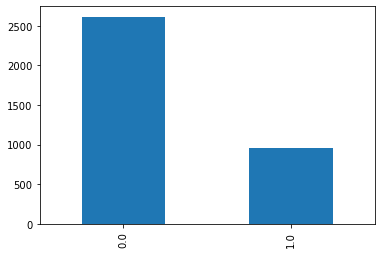

In [122]:
df.opinion.value_counts().plot(kind='bar');

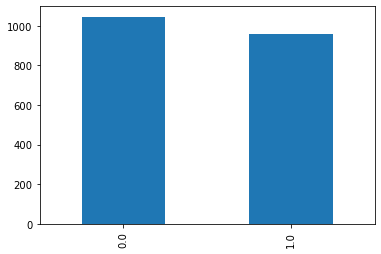

In [127]:
dx = df.drop(df['opinion'][df['opinion'] == 0].sample(frac=0.60, random_state=42).index)
dx.opinion.value_counts().plot(kind='bar');

In [128]:
from keras.utils import to_categorical

X = tfidf.fit_transform(dx["text"]).toarray()
#y = to_categorical(df[["right","left"]])
#y = to_categorical(df["opinion"])
#y = to_categorical(sub['republican.vote'])
y = dx["opinion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)
np.shape(y)

(2006,)

In [167]:
import statsmodels.api as sm
import statistics
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [231]:
def get_sentences(text, words):
    # take text and test every sentences for a list of words
    # if any word from the list in a sentence, join thoses sentenses into a list
    if type(words) is list:
        sentenses = [sentence + '.' for sentence in text.split('. ') if any(w in sentence for w in words)]
    else:
        sentenses = [sentence + '.' for sentence in text.split('. ') if words in sentence]
    print(sentenses)
    return sentenses

In [210]:
def get_sentiment(text, keyword):
    # get sentences where keyword is present 
    sentences = get_sentences(text, keyword)
    if len(sentences) != 0:
        # sentiment analysis
        sentiment = statistics.mean([sid.polarity_scores(s)['compound'] for s in sentences])
    else :
        sentiment = 0
    return sentiment

In [164]:
def get_best(df, keyword):
    # get sentences where keyword is present 
    df[keyword] = df['text'].apply(lambda x: get_sentences(x, keyword))
    # select df where there is more than 0 sentence
    sub = df[keyword].loc[df[keyword].map(lambda d: len(d)) > 0]
    # sentiment analysis
    sub['sentiment'] = sub[keyword].apply(lambda l: statistics.mean([sid.polarity_scores(e)['compound'] for e in l]) )
    # avg sentiment for all sentences containing  the keyword
    avg_sent = review.groupby(by='biz_id').mean().sort_values('sentiment', ascending=False)
    #top = pd.merge(avg_sent, biz[['id', 'name', 'review_count', 'rating', 'price', 'location']], left_on='biz_id', right_on='id')
    return top

In [252]:
text = 'MOSCOW (AP) — Former National Security Agency systems analyst Edward Snowden says surveillance programs used by the United States to tap into phone and Internet connections around the world are making people less safe.\n\nIn short video clips posted by the WikiLeaks website on Friday, Snowden said the NSA mass surveillance he revealed before fleeing to Russia "puts us at risk of coming into conflict with our own government."\n\nSnowden, who faces espionage charges in the U.S. over the leak, described the techniques as "dragnet mass surveillance that puts entire populations under sort of an eye that sees everything even when it\'s not needed."\n\n"They hurt our economy. They hurt our country. They limit our ability to speak and think and live and be creative, to have relationships and to associate freely," Snowden said.\n\nThe videos are the first of Snowden speaking since July 12, when he was shown at a Moscow airport pleading with Russian authorities to grant him asylum, which they did on Aug. 1.\n\nThat decision has strained the relations between the U.S. and Russia. President Barack Obama called off a meeting with President Vladimir Putin at a summit hosted by Russia in September.\n\nSnowden said the U.S. government was "unwilling to prosecute high officials who lied to Congress and the country on camera, but they\'ll stop at nothing to persecute someone who told them the truth."\n\nIn a note accompanying the videos, WikiLeaks said Snowden spoke on Wednesday in Moscow as he accepted the Sam Adams Award, given annually by a group of retired U.S. national security officers and named for a CIA analyst during the Vietnam War who accused the U.S. military of deliberately underestimating the enemy\'s strength for political purposes.\n\nFour former U.S. government officials who were at the ceremony told The Associated Press on Thursday that Snowden is adjusting to life in Russia and said they saw no evidence that he was under the control of local security services. They refused to say where they met with Snowden or where he is living.'

In [186]:
text = preclean_text(text)
text

'MOSCOW (AP) — Former National Security Agency systems analyst Edward Snowden says surveillance programs used by the United States to tap into phone and Internet connections around the world are making people less safe. In short video clips posted by the WikiLeaks website on Friday, Snowden said the NSA mass surveillance he revealed before fleeing to Russia "puts us at risk of coming into conflict with our own government." Snowden, who faces espionage charges in the U.S. over the leak, described the techniques as "dragnet mass surveillance that puts entire populations under sort of an eye that sees everything even when it\'s not needed." "They hurt our economy. They hurt our country. They limit our ability to speak and think and live and be creative, to have relationships and to associate freely," Snowden said. The videos are the first of Snowden speaking since July 12, when he was shown at a Moscow airport pleading with Russian authorities to grant him asylum, which they did on Aug. 1

In [232]:
get_sentiment(text, 'CIA')

['national security officers and named for a CIA analyst during the Vietnam War who accused the U.S.']


-0.5719

In [233]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [236]:
from textblob import TextBlob

sentiment = TextBlob('national security officers and named for a CIA analyst during the Vietnam War who accused the U.S.').sentiment
print(sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [247]:
#pip install spacytextblob
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
doc._.polarity

-0.125

In [261]:
doc = nlp(text)
doc.vocab.strings[u'ORG']
doc.ents

#print([(X.text, X.label_) for X in doc.ents if X.label_=='ORG'])
print([(X.text, X.label_) for X in doc.ents])

[('MOSCOW', 'GPE'), ('AP', 'ORG'), ('National Security Agency', 'ORG'), ('Edward Snowden', 'PERSON'), ('the United States', 'GPE'), ('Friday', 'DATE'), ('Snowden', 'ORG'), ('NSA', 'ORG'), ('Russia', 'GPE'), ('U.S.', 'GPE'), ('first', 'ORDINAL'), ('Snowden', 'GPE'), ('July 12', 'DATE'), ('Moscow', 'GPE'), ('Russian', 'NORP'), ('Aug. 1', 'DATE'), ('U.S.', 'GPE'), ('Russia', 'GPE'), ('Barack Obama', 'PERSON'), ('Vladimir Putin', 'PERSON'), ('Russia', 'GPE'), ('September', 'DATE'), ('U.S.', 'GPE'), ('Congress', 'ORG'), ('Snowden', 'ORG'), ('Wednesday', 'DATE'), ('Moscow', 'GPE'), ('the Sam Adams Award', 'PERSON'), ('annually', 'DATE'), ('U.S.', 'GPE'), ('CIA', 'ORG'), ('the Vietnam War', 'EVENT'), ('U.S.', 'GPE'), ('Four', 'CARDINAL'), ('U.S.', 'GPE'), ('The Associated Press', 'ORG'), ('Thursday', 'DATE'), ('Snowden', 'ORG'), ('Russia', 'GPE'), ('Snowden', 'GPE')]


In [272]:
#labels = [x.text for x in doc.ents]
labels = [x.label_ for x in doc.ents]
Counter(labels)
#sorted(Counter(labels), key=lambda x: x[1])

Counter({'GPE': 16,
         'ORG': 9,
         'PERSON': 4,
         'DATE': 7,
         'ORDINAL': 1,
         'NORP': 1,
         'EVENT': 1,
         'CARDINAL': 1})